In [1]:
# Import libraries
import sys
sys.path.append('../')
import matplotlib.pyplot as plt
import sklearn.model_selection as sms
import sklearn.linear_model as slm
import sklearn.preprocessing as skp
import sklearn.feature_selection as skf
from sklearn.cluster import DBSCAN
import numpy as np
from IPython.display import HTML
import util
from scipy.spatial import cKDTree
from lassonet import LassoNetRegressor, LassoNetRegressorCV
import os
import pandas as pd
import pickle
from torch.optim import SGD, Adam
from functools import partial
import torch
import torch.nn.functional as F
import traceback
from scipy import stats

In [2]:
# Augment with CHH data
X0_gt = np.load('/home/ali/RadDBS-QSM/data/npy/old/X0_gt_chh_rois.npy')
df = pd.read_csv('/home/ali/RadDBS-QSM/data/xlxs/updrs_iii_chh.csv')
# Patient IDs
subject_id = np.asarray(df[df.columns[0]])[1:]
n_rois = 6
# Data
s_directory = open('/home/ali/RadDBS-QSM/data/roi/roi_list','r').read().splitlines()
# Load
with open('/home/ali/RadDBS-QSM/data/pickles/segs_chh', "rb") as fp:  
    segs = pickle.load(fp)
    n_cases = len(segs)
with open('/home/ali/RadDBS-QSM/data/pickles/qsms_chh', "rb") as fp:  
    qsms = pickle.load(fp)
with open('/home/ali/RadDBS-QSM/data/phi/chh/Phi_mcl_gt_roi_chh', "rb") as fp:  
    Phi_gt = pickle.load(fp)
L = int(len(X0_gt)/n_cases)
n_features = int(L/n_rois)
# Only extract ROI if it is present in all cases
seg_labels_all = segs[0]
case_number = np.zeros_like(np.asarray(s_directory))
for i in range(n_cases):
    case_number[i] = float(s_directory[i][-2:])
subject_id_corr = subject_id[np.in1d(subject_id,case_number)]
for i in range(n_cases):
    try:
        print('Found ROIs',str(np.unique(segs[i])),'at segmentation directory file',s_directory[i],'for case',str(subject_id_corr[i]))
    except:
        print('Case',subject_id[i],'quarantined')
pre_updrs_iii_off =  np.asarray(df[df.columns[3]][1:][np.in1d(subject_id,subject_id_corr)]).astype(float)                             
pre_updrs_iii_on =  np.asarray(df[df.columns[4]][1:][np.in1d(subject_id,subject_id_corr)]).astype(float) 
post_updrs_iii_off =  np.asarray(df[df.columns[6]][1:][np.in1d(subject_id,subject_id_corr)]).astype(float) 

per_change = (pre_updrs_iii_off-post_updrs_iii_off)/pre_updrs_iii_off
pre_updrs_off = pre_updrs_iii_off
X_all_c = X0_gt.reshape(n_cases,n_rois,n_features)
X_all_c = X_all_c[:,0:4,:]

lct_change = (pre_updrs_iii_off-pre_updrs_iii_on)/pre_updrs_iii_off
pre_imp = lct_change
# X_all_c = X_all_c.reshape(X_all_c.shape[0],z-1)
# X_all_c = np.append(X_all_c,pre_imp.reshape(-1,1),axis=1)
subsc = subject_id_corr
subs_init = subsc

Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000001 for case 1.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000002 for case 2.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000003 for case 3.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000004 for case 4.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000005 for case 5.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000006 for case 6.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000007 for case 7.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000008 for case 8.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000009 for case 9.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000010 for case 10.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000011 for case 11.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segm

In [3]:
# Training parameters
scoring = 'r2'
results_bls = np.zeros_like(per_change)
results_ls = np.zeros_like(per_change)
scaler = skp.StandardScaler()
#X = X_all_c.astype(float)#scaler.fit_transform(np.asarray(X_all_c,dtype=float).reshape(X_all_c.shape[0],-1))
epsilon = 1e-1
ledd = np.zeros_like(per_change)
cvn = 6
# Train
for j in np.arange(len(subsc)):
    test_id = subsc[j]
    test_index = subsc == test_id
    train_index = subsc != test_id
    X_train = X_all_c[train_index,:,:]
    X_test = X_all_c[test_index,:,:]
    y_train = per_change[train_index]
    y_test = per_change[test_index]
    # Try this with common scaling
    X0_ss0,scaler_ss,X_test_ss0 = util.model_scale(skp.StandardScaler(),
                                                X_train,train_index,X_test,
                                                test_index,pre_updrs_off,ledd,None,None,None,None,None,None,None,None,False,False,False)
    with np.errstate(divide='ignore', invalid='ignore'):
      # Feature selection
      sel = skf.SelectKBest(skf.r_regression,k='all')
      X0_ss = sel.fit_transform(X0_ss0,y_train)
      X_test_ss = sel.transform(X_test_ss0)
      y_n = cKDTree(X0_ss).query(X_test_ss, k=1)[1]
    
      Xy = np.dot(X0_ss.T,y_train)
    if Xy.ndim == 1:
        Xy = Xy[:, np.newaxis]
    alpha_max = np.sqrt(np.sum(Xy**2, axis=1)).max()/len(y_train) 
    alphas = np.linspace(alpha_max*1e-3,alpha_max,10)
    # LASSO
    lasso = slm.LassoCV(max_iter=int(1e5),n_jobs=-1,cv=cvn,alphas=alphas,random_state=0)
    est_ls = lasso.fit(X0_ss,y_train)
    print('LassoCV score:',est_ls.score(X0_ss,y_train))
    results_ls[j] = est_ls.predict(X_test_ss).item()
    print('Lasso predicts',str(np.round(results_ls[j],2)),
          'with regularization',str(np.round(est_ls.alpha_,5)))
    # LASSONet
    lr=1e-5 # NOT ACTUALLY PASSING
    lassonet = LassoNetRegressorCV(
    cv=cvn,
    M=1e-16, # Approximate standard LASSO
    batch_size=len(y_train), # Leads to gradient descent optimization
    hidden_dims=(5,), #CHANGE
    #n_iters=(int(1e4),int(1e2)), # Iterations for objective function and path
    tol=0.99,#1-est_ls.tol,  
    lambda_seq=alphas, # Path multipler and initial lambda disregarded
    optim=partial(SGD,lr=lr,momentum=0.9), # Approximate coordinate descent
    #backtrack=True, # Approximate monotonic coordinate descent path
    verbose=1,
    torch_seed=0,
    random_state=0,
    gamma=0.0, # No L2 regularization
    gamma_skip=0.0, # No L2 regularization on skip connection
    patience=None, # Disable early stopping
    val_size=0.1,
    )
    # What should these norms be...besides nonzero?
    est_lsn = lassonet.fit(X0_ss,y_train)
  
    print('LassoNetCV score:',est_lsn.score(X0_ss,y_train))
    results_bls[j] = est_lsn.predict(X_test_ss).item()

    # Training status
    print('Lasso predicts',str(np.round(results_ls[j],2)),
          'with regularization',str(np.round(est_ls.alpha_,5)),
          'and',str(np.sum(est_ls.coef_!=0)),'nonzero coefficients',
          'and LassoNet predicts',str(np.round(results_bls[j],2)),
          'for case',str(int(subsc[j])),'with',str(np.round(per_change[j],2)))



LassoCV score: 9.325873406851315e-15
Lasso predicts 0.57 with regularization 0.10515


Choosing lambda with cross-validation: 100%|██████████| 6/6 [01:12<00:00, 12.00s/it]


Lambda start: 0.00010514676204212955
LassoNetCV score: 0.9310309749361484
Lasso predicts 0.57 with regularization 0.10515 and 1 nonzero coefficients and LassoNet predicts 0.74 for case 1 with 0.72
LassoCV score: 0.7920259724716745
Lasso predicts 0.51 with regularization 0.03562


Choosing lambda with cross-validation: 100%|██████████| 6/6 [00:55<00:00,  9.27s/it]


Lambda start: 0.00010664623509202634
LassoNetCV score: 0.946086231682012
Lasso predicts 0.51 with regularization 0.03562 and 16 nonzero coefficients and LassoNet predicts 0.5 for case 2 with 0.47
LassoCV score: 0.9678280928202933
Lasso predicts 0.77 with regularization 0.01212


Choosing lambda with cross-validation: 100%|██████████| 6/6 [00:55<00:00,  9.31s/it]


Lambda start: 0.00010822785204402868
LassoNetCV score: 0.9425936199966803
Lasso predicts 0.77 with regularization 0.01212 and 29 nonzero coefficients and LassoNet predicts 0.92 for case 3 with 0.69
LassoCV score: 0.7839565314508254
Lasso predicts 0.58 with regularization 0.03588


Choosing lambda with cross-validation: 100%|██████████| 6/6 [00:59<00:00,  9.88s/it]


Lambda start: 0.0001074354084490981
LassoNetCV score: 0.9547503924181452
Lasso predicts 0.58 with regularization 0.03588 and 17 nonzero coefficients and LassoNet predicts 0.7 for case 4 with 0.42
LassoCV score: 0.6599517440648446
Lasso predicts 0.57 with regularization 0.04466


Choosing lambda with cross-validation: 100%|██████████| 6/6 [00:58<00:00,  9.73s/it]


Lambda start: 0.00010036359567121217
LassoNetCV score: 0.915661604960488
Lasso predicts 0.57 with regularization 0.04466 and 15 nonzero coefficients and LassoNet predicts 0.48 for case 5 with 0.15
LassoCV score: 0.6715612405341714
Lasso predicts 0.55 with regularization 0.04601


Choosing lambda with cross-validation: 100%|██████████| 6/6 [00:43<00:00,  7.18s/it]


Lambda start: 0.00010339669859422713
LassoNetCV score: 0.9472415245950353
Lasso predicts 0.55 with regularization 0.04601 and 17 nonzero coefficients and LassoNet predicts 0.49 for case 6 with 0.44
LassoCV score: 0.7901245742995024
Lasso predicts 0.66 with regularization 0.03413


Choosing lambda with cross-validation: 100%|██████████| 6/6 [01:09<00:00, 11.58s/it]


Lambda start: 0.00010220000905583082
LassoNetCV score: 0.9607310868695721
Lasso predicts 0.66 with regularization 0.03413 and 20 nonzero coefficients and LassoNet predicts 0.73 for case 7 with 0.88
LassoCV score: 0.7953372557071289
Lasso predicts 0.51 with regularization 0.03476


Choosing lambda with cross-validation: 100%|██████████| 6/6 [01:10<00:00, 11.68s/it]


Lambda start: 0.00010408350771967274
LassoNetCV score: 0.9351585284325928
Lasso predicts 0.51 with regularization 0.03476 and 17 nonzero coefficients and LassoNet predicts 0.46 for case 8 with 0.4
LassoCV score: 0.9717412480809773
Lasso predicts 0.6 with regularization 0.01162


Choosing lambda with cross-validation: 100%|██████████| 6/6 [01:09<00:00, 11.52s/it]


Lambda start: 0.00010377740745079964
LassoNetCV score: 0.9343380292136096
Lasso predicts 0.6 with regularization 0.01162 and 31 nonzero coefficients and LassoNet predicts 0.52 for case 9 with 0.6
LassoCV score: 0.9999973049470543
Lasso predicts 0.5 with regularization 0.00011


Choosing lambda with cross-validation: 100%|██████████| 6/6 [01:05<00:00, 10.95s/it]


Lambda start: 0.00010662580455584098
LassoNetCV score: 0.9358832403331638
Lasso predicts 0.5 with regularization 0.00011 and 45 nonzero coefficients and LassoNet predicts 0.48 for case 10 with 0.81
LassoCV score: 0.9717564171204529
Lasso predicts 0.73 with regularization 0.01178


Choosing lambda with cross-validation: 100%|██████████| 6/6 [01:11<00:00, 11.92s/it]


Lambda start: 0.00010518835693905853
LassoNetCV score: 0.9608669285306627
Lasso predicts 0.73 with regularization 0.01178 and 27 nonzero coefficients and LassoNet predicts 0.74 for case 11 with 0.64
LassoCV score: 0.9645816261774185
Lasso predicts 0.56 with regularization 0.01263


Choosing lambda with cross-validation: 100%|██████████| 6/6 [01:06<00:00, 11.13s/it]


Lambda start: 0.00011272399375027192
LassoNetCV score: 0.9396627268787382
Lasso predicts 0.56 with regularization 0.01263 and 29 nonzero coefficients and LassoNet predicts 0.59 for case 13 with 0.72
LassoCV score: 0.9999975155917136
Lasso predicts 0.62 with regularization 0.0001


Choosing lambda with cross-validation: 100%|██████████| 6/6 [01:00<00:00, 10.14s/it]


Lambda start: 0.00010292342089862934
LassoNetCV score: 0.9831792338391561
Lasso predicts 0.62 with regularization 0.0001 and 43 nonzero coefficients and LassoNet predicts 0.59 for case 14 with 0.31
LassoCV score: 0.8981226207969186
Lasso predicts 0.48 with regularization 0.02337


Choosing lambda with cross-validation: 100%|██████████| 6/6 [00:59<00:00,  9.85s/it]


Lambda start: 0.00010480680852549647
LassoNetCV score: 0.9419245604409549
Lasso predicts 0.48 with regularization 0.02337 and 23 nonzero coefficients and LassoNet predicts 0.49 for case 16 with 0.68
LassoCV score: 0.8896350886875815
Lasso predicts 0.46 with regularization 0.02347


Choosing lambda with cross-validation: 100%|██████████| 6/6 [00:58<00:00,  9.82s/it]


Lambda start: 0.00010525187082352603
LassoNetCV score: 0.9389789685877474
Lasso predicts 0.46 with regularization 0.02347 and 22 nonzero coefficients and LassoNet predicts 0.38 for case 18 with 0.34
LassoCV score: 0.9728800818990946
Lasso predicts 0.48 with regularization 0.01166


Choosing lambda with cross-validation: 100%|██████████| 6/6 [01:04<00:00, 10.81s/it]


Lambda start: 0.00010414442041608566
LassoNetCV score: 0.8728954344098885
Lasso predicts 0.48 with regularization 0.01166 and 28 nonzero coefficients and LassoNet predicts 0.28 for case 19 with 0.59
LassoCV score: 0.8863767948898792
Lasso predicts 0.66 with regularization 0.02349


Choosing lambda with cross-validation: 100%|██████████| 6/6 [00:54<00:00,  9.14s/it]


Lambda start: 0.00010534056114274049
LassoNetCV score: 0.9430847862371011
Lasso predicts 0.66 with regularization 0.02349 and 27 nonzero coefficients and LassoNet predicts 0.6 for case 20 with 0.94
LassoCV score: 0.8974789308087396
Lasso predicts 0.73 with regularization 0.0225


Choosing lambda with cross-validation: 100%|██████████| 6/6 [01:10<00:00, 11.67s/it]


Lambda start: 0.00010091544598757371
LassoNetCV score: 0.8967613052032163
Lasso predicts 0.73 with regularization 0.0225 and 23 nonzero coefficients and LassoNet predicts 0.64 for case 21 with 0.84
LassoCV score: 0.9758689345308533
Lasso predicts 0.29 with regularization 0.00977


Choosing lambda with cross-validation: 100%|██████████| 6/6 [01:09<00:00, 11.61s/it]


Lambda start: 8.720057597676787e-05
LassoNetCV score: 0.9304332798470119
Lasso predicts 0.29 with regularization 0.00977 and 29 nonzero coefficients and LassoNet predicts 0.35 for case 22 with 0.1
LassoCV score: 0.9999975289110306
Lasso predicts 0.45 with regularization 0.0001


Choosing lambda with cross-validation: 100%|██████████| 6/6 [01:09<00:00, 11.56s/it]


Lambda start: 0.00010415953832338453
LassoNetCV score: 0.927265805961831
Lasso predicts 0.45 with regularization 0.0001 and 46 nonzero coefficients and LassoNet predicts 0.43 for case 23 with 0.41
LassoCV score: 0.9724629469663969
Lasso predicts 0.63 with regularization 0.01162


Choosing lambda with cross-validation: 100%|██████████| 6/6 [01:04<00:00, 10.82s/it]


Lambda start: 0.00010375838731416488
LassoNetCV score: 0.9048418947855315
Lasso predicts 0.63 with regularization 0.01162 and 30 nonzero coefficients and LassoNet predicts 0.8 for case 24 with 0.57
LassoCV score: 0.9999974648703529
Lasso predicts 0.72 with regularization 0.0001


Choosing lambda with cross-validation: 100%|██████████| 6/6 [01:07<00:00, 11.25s/it]


Lambda start: 0.00010356846765887074
LassoNetCV score: 0.8825065674512157
Lasso predicts 0.72 with regularization 0.0001 and 53 nonzero coefficients and LassoNet predicts 0.65 for case 25 with 0.66
LassoCV score: 0.9007150132427456
Lasso predicts 0.59 with regularization 0.02315


Choosing lambda with cross-validation: 100%|██████████| 6/6 [01:03<00:00, 10.59s/it]


Lambda start: 0.0001037927692885411
LassoNetCV score: 0.8577491032411383
Lasso predicts 0.59 with regularization 0.02315 and 25 nonzero coefficients and LassoNet predicts 0.49 for case 26 with 0.63
LassoCV score: 0.9999976566238157
Lasso predicts 0.6 with regularization 0.0001


Choosing lambda with cross-validation: 100%|██████████| 6/6 [01:03<00:00, 10.59s/it]


Lambda start: 0.00010239807065900299
LassoNetCV score: 0.8743104479908324
Lasso predicts 0.6 with regularization 0.0001 and 45 nonzero coefficients and LassoNet predicts 0.54 for case 27 with 0.47
LassoCV score: 0.8998847100114885
Lasso predicts 0.43 with regularization 0.0222


Choosing lambda with cross-validation: 100%|██████████| 6/6 [01:02<00:00, 10.44s/it]


Lambda start: 9.95550844830892e-05
LassoNetCV score: 0.8998710665206758
Lasso predicts 0.43 with regularization 0.0222 and 24 nonzero coefficients and LassoNet predicts 0.4 for case 28 with 0.28
LassoCV score: 0.8037513659197076
Lasso predicts 0.65 with regularization 0.0347


Choosing lambda with cross-validation: 100%|██████████| 6/6 [00:57<00:00,  9.65s/it]


Lambda start: 0.00010390574575083613
LassoNetCV score: 0.862223547103244
Lasso predicts 0.65 with regularization 0.0347 and 17 nonzero coefficients and LassoNet predicts 0.65 for case 29 with 0.59
LassoCV score: 0.796258956098367
Lasso predicts 0.68 with regularization 0.03542


Choosing lambda with cross-validation: 100%|██████████| 6/6 [01:00<00:00, 10.14s/it]


Lambda start: 0.00010604274159639285
LassoNetCV score: 0.8922474619000088
Lasso predicts 0.68 with regularization 0.03542 and 22 nonzero coefficients and LassoNet predicts 0.61 for case 30 with 0.53
LassoCV score: 0.7907419471112881
Lasso predicts 0.57 with regularization 0.03452


Choosing lambda with cross-validation: 100%|██████████| 6/6 [00:58<00:00,  9.72s/it]


Lambda start: 0.00010334891053617935
LassoNetCV score: 0.9055939598197323
Lasso predicts 0.57 with regularization 0.03452 and 18 nonzero coefficients and LassoNet predicts 0.62 for case 31 with 0.86
LassoCV score: 0.8993151123301029
Lasso predicts 0.5 with regularization 0.02303


Choosing lambda with cross-validation: 100%|██████████| 6/6 [01:08<00:00, 11.40s/it]


Lambda start: 0.00010327002875449353
LassoNetCV score: 0.8711492855276057
Lasso predicts 0.5 with regularization 0.02303 and 23 nonzero coefficients and LassoNet predicts 0.49 for case 32 with 0.48
LassoCV score: 0.8075984338649802
Lasso predicts 0.7 with regularization 0.03437


Choosing lambda with cross-validation: 100%|██████████| 6/6 [01:05<00:00, 10.84s/it]


Lambda start: 0.00010290648649499963
LassoNetCV score: 0.8638132795224378
Lasso predicts 0.7 with regularization 0.03437 and 18 nonzero coefficients and LassoNet predicts 0.72 for case 33 with 0.66
LassoCV score: 0.7993122176326131
Lasso predicts 0.53 with regularization 0.03553


Choosing lambda with cross-validation: 100%|██████████| 6/6 [01:09<00:00, 11.62s/it]


Lambda start: 0.00010637518117607356
LassoNetCV score: 0.8851647736589898
Lasso predicts 0.53 with regularization 0.03553 and 20 nonzero coefficients and LassoNet predicts 0.51 for case 34 with 0.33
LassoCV score: 0.8951601025975016
Lasso predicts 0.49 with regularization 0.02369


Choosing lambda with cross-validation: 100%|██████████| 6/6 [01:08<00:00, 11.34s/it]


Lambda start: 0.0001062516784143694
LassoNetCV score: 0.8903593804560774
Lasso predicts 0.49 with regularization 0.02369 and 21 nonzero coefficients and LassoNet predicts 0.4 for case 35 with 0.49
LassoCV score: 0.8939229742522596
Lasso predicts 0.7 with regularization 0.02323


Choosing lambda with cross-validation: 100%|██████████| 6/6 [01:09<00:00, 11.54s/it]


Lambda start: 0.00010416148302657408
LassoNetCV score: 0.867393926315638
Lasso predicts 0.7 with regularization 0.02323 and 24 nonzero coefficients and LassoNet predicts 0.62 for case 36 with 0.78
LassoCV score: 0.9054378273130355
Lasso predicts 0.57 with regularization 0.02238


Choosing lambda with cross-validation: 100%|██████████| 6/6 [01:02<00:00, 10.48s/it]


Lambda start: 0.00010037946640202495
LassoNetCV score: 0.8777456273061123
Lasso predicts 0.57 with regularization 0.02238 and 22 nonzero coefficients and LassoNet predicts 0.6 for case 37 with 0.81
LassoCV score: 0.8983025916108357
Lasso predicts 0.64 with regularization 0.02282


Choosing lambda with cross-validation: 100%|██████████| 6/6 [00:49<00:00,  8.29s/it]


Lambda start: 0.00010232425884383442
LassoNetCV score: 0.8862091839261805
Lasso predicts 0.64 with regularization 0.02282 and 23 nonzero coefficients and LassoNet predicts 0.7 for case 38 with 0.71
LassoCV score: 0.895668287409421
Lasso predicts 0.51 with regularization 0.02279


Choosing lambda with cross-validation: 100%|██████████| 6/6 [00:55<00:00,  9.27s/it]


Lambda start: 0.00010218976698484276
LassoNetCV score: 0.8859477404337166
Lasso predicts 0.51 with regularization 0.02279 and 21 nonzero coefficients and LassoNet predicts 0.54 for case 39 with 0.32
LassoCV score: 0.8175058150369485
Lasso predicts 0.67 with regularization 0.03209


Choosing lambda with cross-validation: 100%|██████████| 6/6 [00:51<00:00,  8.58s/it]


Lambda start: 9.608274346350337e-05
LassoNetCV score: 0.8672106910416983
Lasso predicts 0.67 with regularization 0.03209 and 20 nonzero coefficients and LassoNet predicts 0.64 for case 40 with 0.83


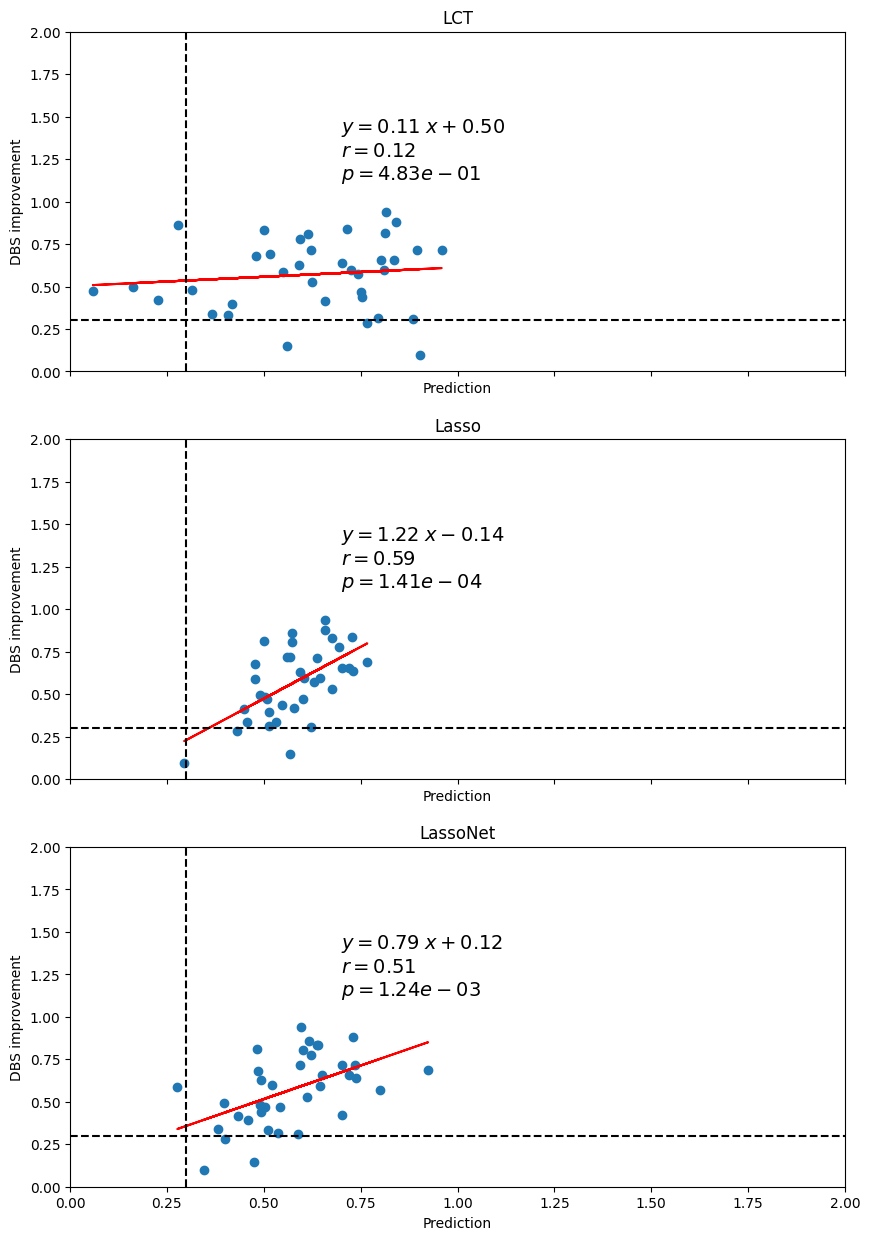

In [4]:
util.eval_prediction(np.vstack((pre_imp,
                               results_ls,
                               results_bls,
                               )),
                               per_change,
                               ['LCT',
                                'Lasso',
                                'LassoNet'
                                ],(30,5))
plt.ylim([0,2])
plt.xlim([0,2])
plt.style.use('default')



Text(0.1, 0.8, '$y=0.79\\; x+0.12$\n$r = 0.51$\n$p = 1.24e-03$')

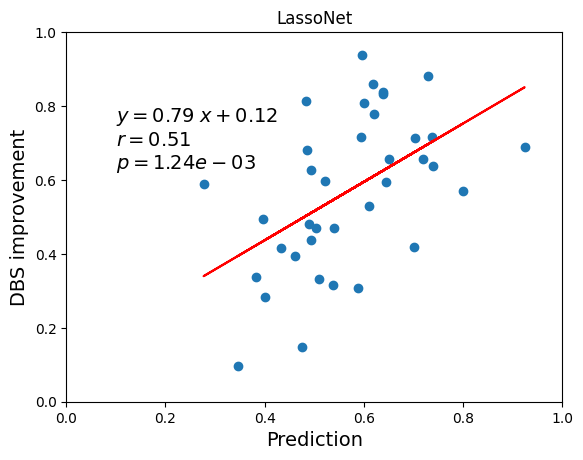

In [5]:
plt.scatter(results_bls,per_change)
lr = stats.linregress(results_bls,per_change)
plt.plot(results_bls,results_bls*lr.slope+lr.intercept,color='r')
plt.xlim(0,1)
plt.ylim(0,1)
plt.title('LassoNet')
plt.ylabel("DBS improvement",fontsize=14)
plt.xlabel("Prediction",fontsize=14)
text = f"$y={lr.slope:0.2f}\; x{lr.intercept:+0.2f}$\n$r = {lr.rvalue:0.2f}$\n$p = {lr.pvalue:0.2e}$"
plt.text(0.1, 0.8, text,
    fontsize=14, verticalalignment='top')

Text(0.1, 0.8, '$y=0.11\\; x+0.50$\n$r = 0.12$\n$p = 4.83e-01$')

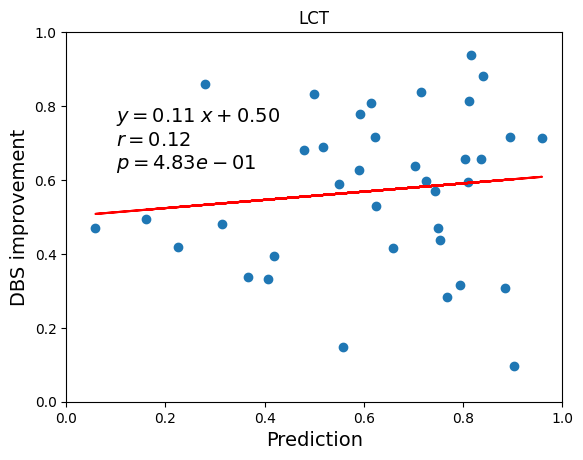

In [6]:
plt.scatter(lct_change,per_change)
lr = stats.linregress(lct_change,per_change)
plt.plot(lct_change,lct_change*lr.slope+lr.intercept,color='r')
plt.xlim(0,1)
plt.ylim(0,1)
plt.title('LCT')
plt.ylabel("DBS improvement",fontsize=14)
plt.xlabel("Prediction",fontsize=14)
text = f"$y={lr.slope:0.2f}\; x{lr.intercept:+0.2f}$\n$r = {lr.rvalue:0.2f}$\n$p = {lr.pvalue:0.2e}$"
plt.text(0.1, 0.8, text,
    fontsize=14, verticalalignment='top')